In [22]:
%matplotlib  inline
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import plotly as py
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from joblib import Parallel, delayed
import scipy.ndimage as ndimage

    
import xgboost
import sklearn.feature_selection as fs
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
import sklearn.preprocessing as prep
from sklearn.metrics import mean_squared_error

from pykalman import KalmanFilter
pd.set_option('display.max_columns', 100)
pd.options.display.max_rows = 150


In [94]:
def macd(close, n_fast=12, n_slow=26,  n_sign=9, fillna=True):
    emafast = close.ewm(n_fast).mean()
    emaslow = close.ewm(n_slow).mean()
    macd = emafast - emaslow
    if fillna:
        macd = macd.fillna(0)
    macdsig = macd.ewm(n_sign).mean()
    if fillna:
        macd = macd.fillna(0)
        macdsig = macdsig.fillna(0)
    return macd, macdsig

def simple_returns(df):
    df = df.pct_change().fillna(0)
    return df

def rsi(close, period=14, fillna=True):
    diff = close.diff()
    which_dn = diff < 0

    up, dn = diff, diff*0
    up[which_dn], dn[which_dn] = 0, -up[which_dn]

    emaup = up.ewm(period).mean()
    emadn = dn.ewm(period).mean()

    rsi = 100 * emaup/(emaup + emadn)
    if fillna:
        rsi = rsi.fillna(50)
    return pd.Series(rsi, name='rsi')

def wavetrend(high,low,close,n1=10,n2=21):
    ap = (high+low+close)/3
    esa = close.ewm(n1).mean()
    d = abs(ap - esa).ewm(n1).mean()
    ci = (ap - esa) / (0.02 * d)
    tci = ci.ewm(n2).mean()
    
    wt1=tci
    wt2=wt1.rolling(n2).mean()
    wt2=wt2.fillna(method ='backfill')
    return wt1, wt2

def log_returns(df):

    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):

    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):

    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, period=14, fillna=False):

    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(period).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):

    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):

    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=2):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    #print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, tolerance):
    """Group extremes by cluster based on relative price distance."""
    # if Dataframe take first column
    if isinstance(iterable,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(iterable,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= tolerance*item:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def highest_high(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).max()
    return df

def momentum(df,period=10):
    df = df - df.shift(period)
    df[0:period] = 0
    return df

def trading_range(df_high,df_low):
    df = df_high-df_low
    return df

def lowest_low(df,period=21):
    df = df.rolling(window=period,center=False,min_periods=1).min()
    return df

def calc_extreme_distance(series,sup_array,res_array):
    import math
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value*1.1 < nearest_sup:
            dist_s.append(curr_value/2)
        elif curr_value > nearest_res*1.1:
            dist_r.append(curr_value/2)
        else:
            sup_val = curr_value-nearest_sup
            res_val = nearest_res-curr_value
            if np.isnan(sup_val):
                sup_val = (curr_value/2)
            if np.isnan(res_val):
                res_val = (curr_value/2)
            dist_s.append(sup_val)
            dist_r.append(res_val)
    if dist_s and dist_r:
        return dist_s,dist_r
    
def r_score(y_true, y_pred, sample_weight=None, multioutput=None):
    r2 = r2_score(y_true, y_pred, sample_weight=sample_weight, multioutput=multioutput)
    r = (np.sign(r2)*np.sqrt(np.abs(r2)))
    if r <= -1:
        return -1
    else:
        return r
    
def calc_r_score (actual_and_test):
    r = []
    r.append(0)
    for i in range(1,len(actual_and_test)):
        ri = r_score(actual_and_test[0:i,0],actual_and_test[0:i,1])
        if ri <= -1:
            ri = 0
        r.append(ri)
    return r

def calc_kalman(dataframe):
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = dataframe.values
    else:
        array = dataframe
    kf = KalmanFilter(transition_matrices = [1],
                      observation_matrices = [1],
                      initial_state_mean = 0,
                      initial_state_covariance = 1,
                      observation_covariance=1,
                      transition_covariance=.01)
    state_means, _ = kf.filter(array)
    state_means = state_means.flatten()
    state_means = pd.DataFrame(data=state_means,index=dataframe.index)
    state_means.columns = ['KF']
    state_means["KF"][0:9]  = float(np.mean(state_means[9:15]).values)
    return state_means

def calc_extreme_groups (dataframe,find_max=True,mDistance = 100,tolerance=0.0009,signi_level=1):
    """Group extremes by cluster based on absolute price distance.
       Input: series or dataframe
       find_max: maximum (resistance) or minimum (suppport) search
       mDistance: minimumdistance in an array to find local extremes
       tolerance: tolerance level in percent to group other extremes
       signi_level: leave 1 """
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values)     
    array = np.ravel(array[local_extreme(array,min_distance= mDistance,find_max=find_max)])
    signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
    extreme = group_extremes(signify,tolerance)
    return array,signify,extreme

def calc_next_extreme_distance (dataframe,extremes_sup=None,extremes_res=None):
    """Given a series and their supports and resistances
    calculate the distances to the next supports or resistances."""
    if isinstance(dataframe,pd.core.frame.DataFrame) or isinstance(dataframe,pd.core.series.Series):
        array = np.ravel(dataframe.values) 
    [sup,res] = calc_extreme_distance(array,extremes_sup,extremes_res) 
    sr = pd.DataFrame(data=np.transpose([sup,res]),index=dataframe.index )
    sr.columns = ['support_distance', 'resistance_distance']
    return sr

import pdb;
def calc_MNE(df):
    MNE_list = []
    time_list = []
    for i in range(len(df)-1):
        if i % 10000 == 0:
            print('rows processed: ' + str(i))
        end_trade = df['endtime'][i]
        signal = df['signal'][i]
        try:
            end_index = df.index.get_loc(end_trade)
        except:
            end_index = len(df)
        data = df[i+1:end_index+1]
        if signal == -1:
            MNE = data['HIGH'].max()
            index = data['HIGH'].idxmax()
        elif signal == 1:
            MNE = data['LOW'].min()
            index = data['LOW'].idxmin()
        else:
            MNE = 0
            print('signal is not -1 or 1')
        MNE_list.append(MNE)
        time_list.append(index-df.index[i])
    MNE_list.append(np.nan)
    time_list.append(np.nan)
    
    #print('lendf: '+ str(len(df)) + ', lenMNE: ' + str(len(MNE_list)) + ', lenMNEdist: ' + str(len(diff_list))  + ', lenMNE_time: ' + str(len(time_list)) )

    df['MNE'] = MNE_list
    diff_list = np.absolute(df['MNE']-df['start_price'])
    df['MNE_distance_from_start'] = diff_list
    df['MNE_time'] = time_list
    return df

def calc_profit_loss(i=None,data=None,profit=0.01):
    start = data['CLOSE'][i]
    starttime = data.index[i]
    if (i+1)>len(data):
        return
    search = data[i+1:]
    longvalue = float('NaN')
    shortvalue = float('NaN')
    try:
        longtime = search[search['HIGH']>=start*(1+profit)].index[0]
        longvalue = search[search['HIGH']>=start*(1+profit)]
        longvalue = longvalue['HIGH'][0]
        
    except Exception as e:
        ts = time.time()
        longtime = datetime.fromtimestamp(ts)
    try:
        shorttime = search[search['LOW']<= start*(1-profit)].index[0]
        shortvalue = search[search['LOW']<= start*(1-profit)]
        shortvalue = shortvalue['LOW'][0]
    except Exception as e:
        ts = time.time()
        shorttime = datetime.fromtimestamp(ts)
    #print( "longtime=" + str(longtime) + ",shorttime=" + str(shorttime))
    #pdb.set_trace()
    if longtime<shorttime:
        return starttime,longtime,1,((longtime-starttime).total_seconds())/3600,start,longvalue
    elif longtime>shorttime:
        return starttime,shorttime,-1,((shorttime-starttime).total_seconds())/3600,start,shortvalue
    elif longtime.date()==shorttime.date() and longtime.minute == shorttime.minute:
        return float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN'),float('NaN')
    
from pyti.stochrsi import stochrsi as stochrsi
from pyti.commodity_channel_index import commodity_channel_index as cci

def feature_engineering_dates(df):
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Week'] = df.index.weekofyear
    df['Weekday'] = df.index.weekday
    df['DayMonth'] = df.index.day
    return df

def feature_engineering_ta(df):

    df['TSI'] = tsi(df['CLOSE'])
    df['ATR'] = average_true_range(df['HIGH'],df['LOW'],df['CLOSE'],period=14)
    df['WT1'],df['WT2'] = wavetrend(df['HIGH'],df['LOW'],df['CLOSE'],n1=10,n2=21)
    df['KF'] = calc_kalman(df['CLOSE'])
    df['KST'] = kst(df['CLOSE'])
    df['HIGHESTHIGH'] = highest_high(df['HIGH'],period=21)
    df['LOWESTLOW'] = lowest_low(df['LOW'],period=21)
    df['TRADINGRANGE'] = trading_range(df['HIGH'],df['LOW'])
    df['MOMENTUM'] = momentum(df['CLOSE'],period=10)
    df['RSI'] = rsi(df['CLOSE'],period=14)
    df['MACD'],df['MACDSIGNAL'] = macd(df['CLOSE'])
    df['STOCHRSI'] = stochrsi(df['CLOSE'], 14)
    df['CCI'] = cci(df['CLOSE'],df['HIGH'],df['LOW'], 20)
    return df

def feature_engineering_statistics(df_grouped,cols):
    for c in cols:
        # rolling
        for h in [11, 21]:
            df_grouped[c+'_rolling_mean_'+str(h)] = df_grouped[c].rolling(h, min_periods=0).mean()
        # diffs
        df_grouped[c+'_diff_1'] = df_grouped[c].diff().fillna(method="backfill")
        df_grouped[c+'_diff_2'] = df_grouped[c].diff(2).fillna(method="backfill")
        df_grouped[c+'_diff_3'] = df_grouped[c].diff(3).fillna(method="backfill")
        # cumsum
        df_grouped[c+'_cumsum'] = df_grouped[c].cumsum()
        # shift columns
        df_grouped[c+'_shift1'] = df_grouped[c].shift(1).fillna(0)
        df_grouped[c+'_shift2'] = df_grouped[c].shift(2).fillna(0)
        df_grouped[c+'_shift3'] = df_grouped[c].shift(3).fillna(0)
    return df_grouped


In [24]:
EURUSD = pd.read_csv('EURUSD.txt',delimiter=',',dtype={'<TIME>': str})
EURUSD.columns = EURUSD.columns.str.replace("<", "")
EURUSD.columns = EURUSD.columns.str.replace(">", "")
EURUSD = EURUSD.drop(['VOL'], axis=1)
EURUSD['DATETIME'] = EURUSD['DTYYYYMMDD'].astype(str) + ":" + EURUSD['TIME'].astype(str)
EURUSD = EURUSD.drop(['DTYYYYMMDD','TIME'], axis=1)
EURUSD['DATETIME']  = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False)
EURUSD.index = pd.to_datetime(EURUSD['DATETIME'],format='%Y%m%d:%H%M%S',  infer_datetime_format=False, unit="m")

In [25]:
EURUSD_1H = EURUSD.resample('1H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_4H = EURUSD.resample('4H').agg({'OPEN': 'first', 
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})

EURUSD_D = EURUSD.resample('1D').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_D = EURUSD_D.pct_change().dropna()
EURUSD_D['Weekday'] = EURUSD_D.index.weekday
EURUSD_D['Month'] = EURUSD_D.index.month
EURUSD_D['DayMonth'] = EURUSD_D.index.day

EURUSD_1H = EURUSD_1H.dropna()
EURUSD_4H = EURUSD_4H.dropna()

EURUSD_M = EURUSD_1H.resample('M').agg({'OPEN': 'first',
                                 'HIGH': 'max', 
                                 'LOW': 'min', 
                                 'CLOSE': 'last'})
EURUSD_M = EURUSD_M.dropna().pct_change().dropna()
EURUSD_M['Month'] = EURUSD_M.index.month

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'Local extremes')

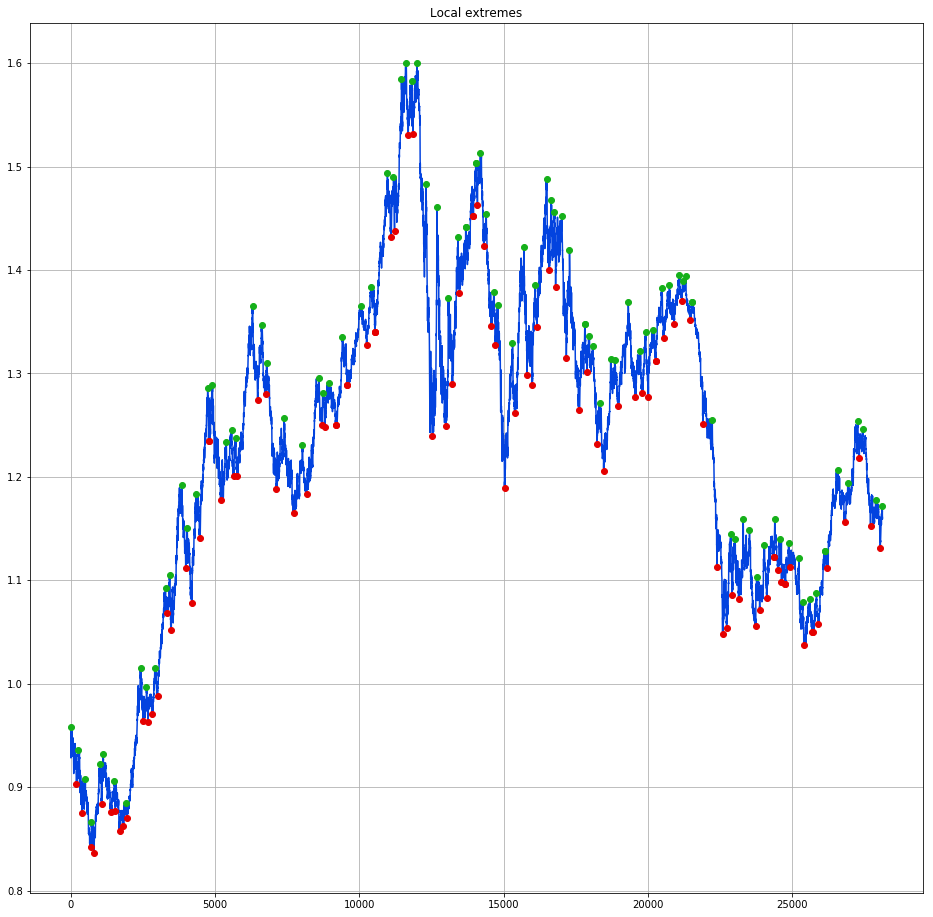

In [26]:
cl=np.ravel(EURUSD_4H[['CLOSE']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 100
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)
plt.title("Local extremes")

# resistance levels

localextremes:100
signify:27  signimax:4.0
extremes:18


C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:265: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'resistances')

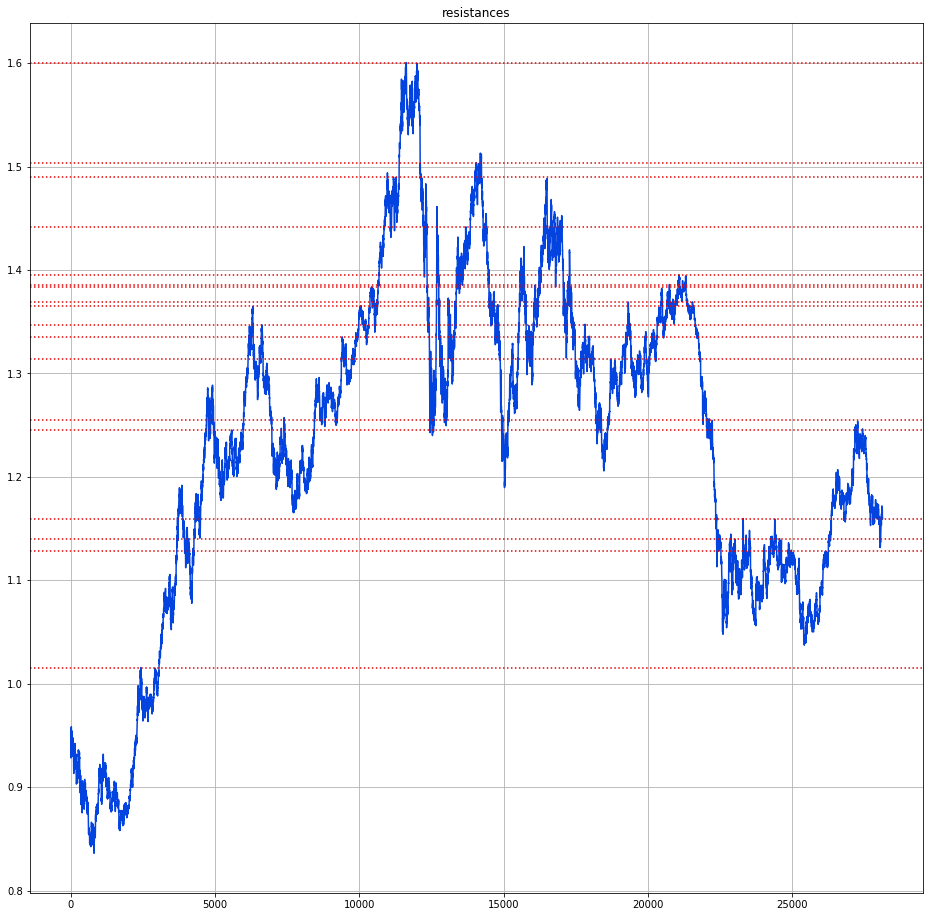

In [27]:
tolerance= 0.001
signi_level=1
min_distance= 100
array = np.ravel(cl[local_extreme(cl,min_distance= min_distance,find_max=False)])
#signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
signify =extreme_significance(array, tolerance=tolerance,signi_level=signi_level)
extreme = group_extremes(signify,tolerance)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
      
_,_,extremes_res = calc_extreme_groups(EURUSD_4H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=True)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)
plt.title("resistances")

# Support levels

localextremes:100
signify:27  signimax:4.0
extremes:18


C:\Users\prof\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:265: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



Text(0.5,1,'Supports')

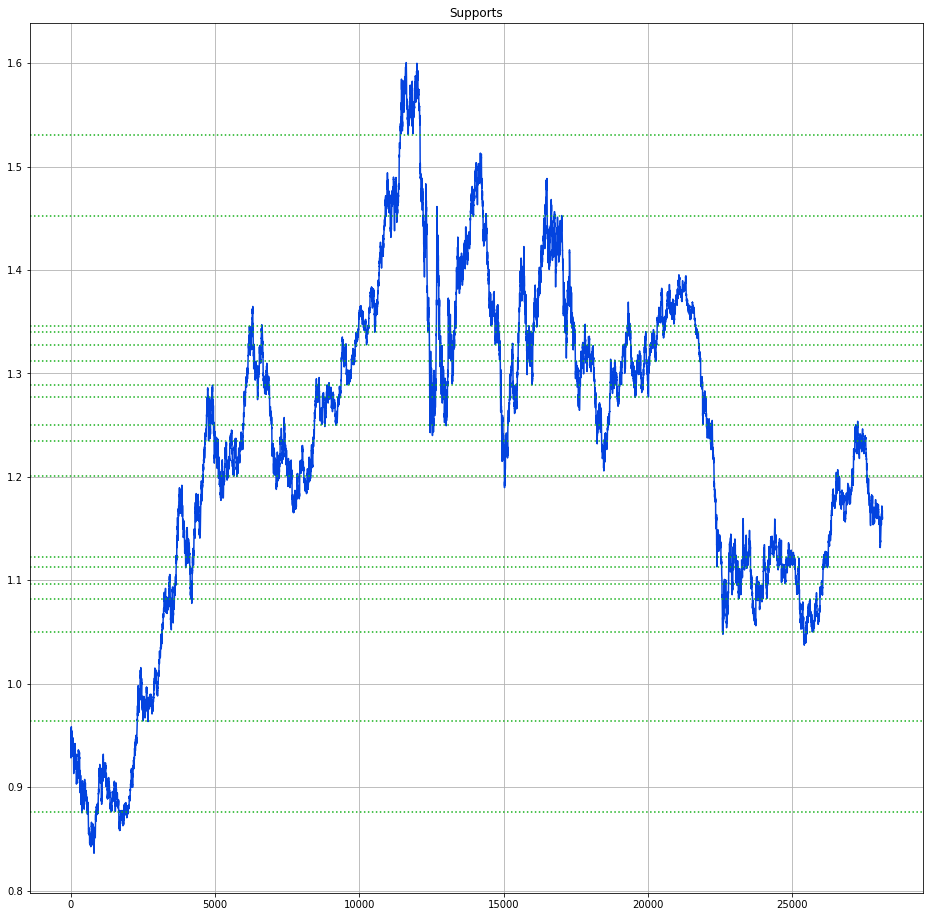

In [31]:
# Show horizontal resistance levels based on extreme points and significance
__,__,extremes_sup = calc_extreme_groups(EURUSD_4H[['CLOSE']],signi_level=signi_level,
                                   tolerance=tolerance,mDistance = min_distance,find_max=False)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
print('localextremes:' + repr(len(array)))
print('signify:' + repr(len(signify)), ' signimax:' +repr(np.max(signify['Significance'])))
print('extremes:' + repr(len(extreme)))
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)
plt.title("Supports")

# add indicators

In [51]:
EURUSD_4H = feature_engineering_dates(EURUSD_4H)
EURUSD_4H = feature_engineering_ta(EURUSD_4H)
EURUSD_4H = EURUSD_4H.fillna(method='bfill')

EURUSD_1H = feature_engineering_dates(EURUSD_1H)
EURUSD_1H = feature_engineering_ta(EURUSD_1H)
EURUSD_1H = EURUSD_1H.fillna(method='bfill')
#cols = ['TSI','ATR','KF','KST','HIGHESTHIGH','LOWESTLOW','TRADINGRANGE','MOMENTUM','RSI','MACD','MACDSIGNAL','WT1','WT2','STOCHRSI','CCI']
#EURUSD_1H = feature_engineering_statistics(EURUSD_1H,cols)

# Create target

In [52]:
profit = 0.0016 # in EURUSD absolute Notation 
data = EURUSD_1H[['HIGH','LOW','CLOSE']]
start = time.time()
inputs = range(len(data))

results = Parallel(n_jobs=4,verbose=1)(delayed(calc_profit_loss)(x, data, profit) for x in inputs)
end = time.time()
print('time elapsed: ' + str(end - start))

results = [x for x in results if x is not None]
results = [x for x in results if str(x) != 'nan']
df = pd.DataFrame(results, columns=['pos','endtime','signal', 'time_diff_hours','start_price','end_price'])
df.index = df['pos']
df = df.drop(['pos'], axis=1)
data_merged = EURUSD_1H.merge(df, left_index=True,right_index =True, how='left')
#data_merged = data_merged.dropna()
data_merged = data_merged[data_merged['time_diff_hours'] !=0]
data_merged['pct_change'] = (data_merged['end_price']/data_merged['start_price'])-1
data_merged['weight'] = 1/data_merged['time_diff_hours']
data_merged['weighted_target'] = data_merged['weight']*data_merged['pct_change']
data_merged.to_csv('EURUSD_1H_signal_data.csv',index =True,index_label='DATETIME')

print('mean holding time in hours: ' + str(data_merged.time_diff_hours.mean()))

# candle big enough to reach SL or TP in 1 move
print('number of 1 hour holding time: ' + str(data_merged[data_merged['time_diff_hours'] ==1].signal.count()))

mean holding time in hours: 6.8097826598961815
number of 1 hour holding time: 26281


In [53]:
data_merged.describe()

OPEN           HIGH            LOW          CLOSE  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean        1.232074       1.233058       1.231099       1.232077   
std         0.159876       0.160008       0.159734       0.159872   
min         0.835500       0.836200       0.835000       0.835400   
25%         1.126600       1.127500       1.125800       1.126600   
50%         1.254300       1.255300       1.253300       1.254300   
75%         1.343400       1.344300       1.342500       1.343400   
max         1.601400       1.603600       1.599000       1.601300   

                Year          Month           Week        Weekday  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean     2009.336536       6.431632      26.229088       2.006772   
std         5.092055       3.412439      14.878914       1.461929   
min      2001.000000       1.000000       1.000000       0.000000   
25%      2005.000000       3.000000      13.000000       1.000000   
50%      2009.000000       6.000000      26.000000       2.000000   
75%      2014.000000       9.000000      39.000000       3.000000   
max      2018.000000      12.000000      53.000000       6.000000   

            DayMonth            TSI            ATR            WT1  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean       15.700678       0.517403       0.001973       1.346631   
std         8.757236      16.442612       0.000878      29.956505   
min         1.000000    -100.000000       0.000400     -71.715085   
25%         8.000000     -11.059933       0.001389     -23.975125   
50%        16.000000       0.832157       0.001782       1.970412   
75%        23.000000      12.128933       0.002322      26.662483   
max        31.000000      53.514986       0.009999      74.035459   

                 WT2             KF            KST    HIGHESTHIGH  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean        1.352304       1.232047       0.061463       1.237282   
std        28.146389       0.159874       4.755534       0.160525   
min       -65.806085       0.837519     -27.782880       0.840400   
25%       -22.196844       1.126325      -2.593164       1.131700   
50%         2.215162       1.254437       0.127900       1.260050   
75%        24.521777       1.343464       2.787176       1.347800   
max        67.491931       1.596783      30.007173       1.603600   

           LOWESTLOW   TRADINGRANGE       MOMENTUM            RSI  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean        1.226829       0.001958       0.000020      50.255535   
std         0.159197       0.001576       0.004987      12.679456   
min         0.835000       0.000000      -0.041700       0.000000   
25%         1.121600       0.000900      -0.002300      41.352651   
50%         1.249500       0.001500       0.000000      50.339361   
75%         1.338000       0.002500       0.002400      59.194807   
max         1.593500       0.033100       0.049300      92.171446   

                MACD     MACDSIGNAL       STOCHRSI            CCI  \
count  108238.000000  108238.000000  108238.000000  108238.000000   
mean        0.000028       0.000029      50.169815       0.008632   
std         0.002484       0.002335      36.032797       2.020301   
min        -0.013403      -0.012318       0.000000     -17.787085   
25%        -0.001372      -0.001299      15.651393      -1.004061   
50%         0.000099       0.000108      50.317244       0.030426   
75%         0.001530       0.001443      84.817573       1.047526   
max         0.020723       0.019505     100.000000      19.485730   

              signal  time_diff_hours    start_price      end_price  \
count  106147.000000    106147.000000  106147.000000  106147.000000   
mean        0.007791         6.809783       1.231914       1.231942   
std         0.999974        11.958871       0.160100       0.160093   


# plot example for wave trend

In [ ]:
start = EURUSD_4H.index.searchsorted(datetime(2001, 1, 22,0))
end = EURUSD_4H.index.searchsorted(datetime(2001, 2, 25))
EURUSD_temp =EURUSD_4H.iloc[start:end]

init_notebook_mode(connected=True)
data = go.Candlestick(x=EURUSD_temp.index, open=EURUSD_temp['OPEN'],high=EURUSD_temp['HIGH'],low=EURUSD_temp['LOW'],
                      close=EURUSD_temp['CLOSE'])

wt1 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT1'],
    name = 'WT1'
)

wt2 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['WT2'],
    name = 'WT2'
)
wt3 = go.Scatter(
    x=EURUSD_temp.index,
    y=EURUSD_temp['STOCHRSI'],
    name = 'STOCHRSI'
)
#py.plotly.iplot(wt,filename='basic_candle', auto_open=True)
fig = tools.make_subplots(rows=2, cols=1)
fig.append_trace(data, 1, 1)
fig.append_trace(wt1, 2, 1)
fig.append_trace(wt2, 2, 1)
#fig.append_trace(wt3, 2, 1)
py.offline.iplot(fig,filename='basic_candle')

# Seasonality in the performance?

# mean weekday performance strategy

Text(0.5,1,'Mean close to close return per weekday')

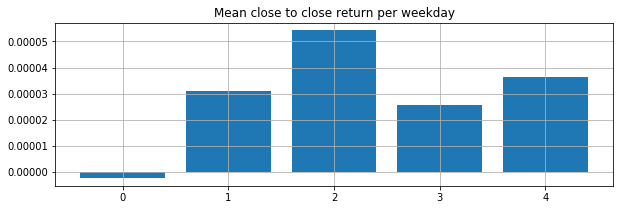

In [60]:
bars = data_merged[data_merged.Weekday <=5].groupby(['Weekday'])['pct_change'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean close to close return per weekda')

# mean weekday performance day to day

Text(0.5,1,'Bar 6 = Sunday 23:00')

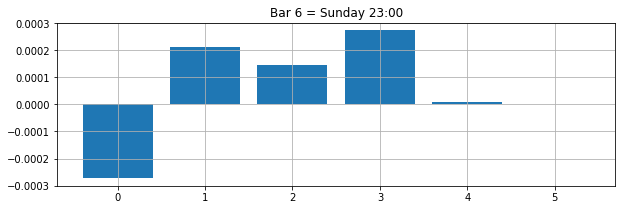

In [64]:
bars = EURUSD_D[EURUSD_D.Weekday <=5].groupby(['Weekday'])['CLOSE'].mean()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Mean day close to day close return per weekday')

# sum weekday signal strategy

Text(0.5,1,'Bar 6 = Sunday 23:00')

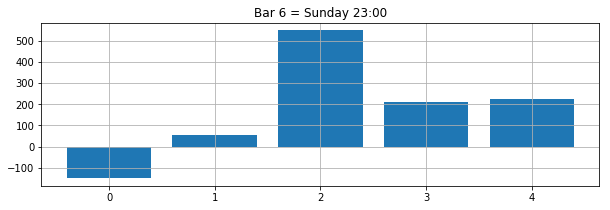

In [68]:
bars = data_merged[data_merged.Weekday <=5].groupby(['Weekday'])['signal'].sum()
plt.rc("figure",figsize=(10,3))
plt.bar(bars.index,bars)
plt.grid()
plt.title('Bar 6 = Sunday 23:00')

# mean daymonth performance strategy

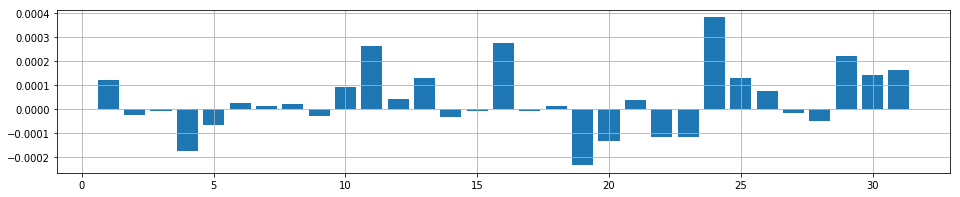

In [88]:
bars = data_merged.groupby(['DayMonth'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean daymonth performance day to day

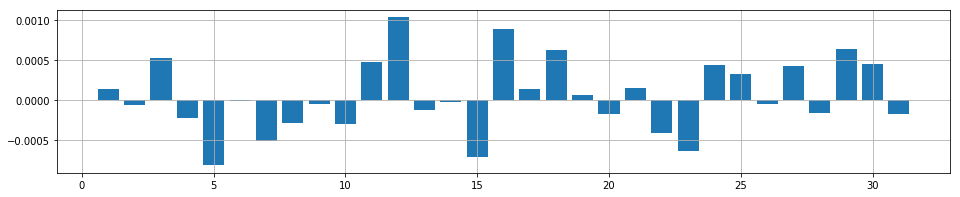

In [89]:
bars = EURUSD_D.groupby(['DayMonth'])['CLOSE'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# sum month signal strategy

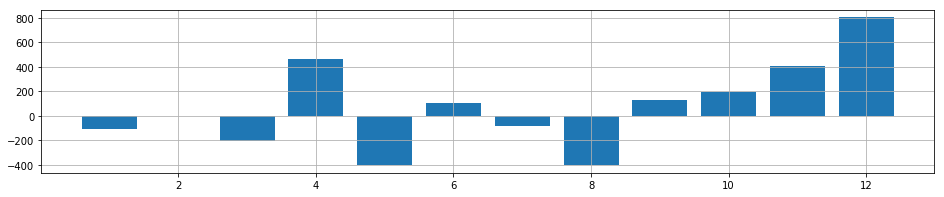

In [91]:
bars = data_merged.groupby(['Month'])['signal'].sum()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month performance month to month

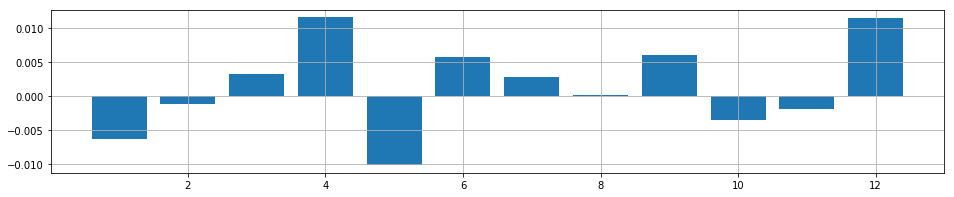

In [92]:
bars = EURUSD_M.groupby(['Month'])['CLOSE'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# mean month performance strategy

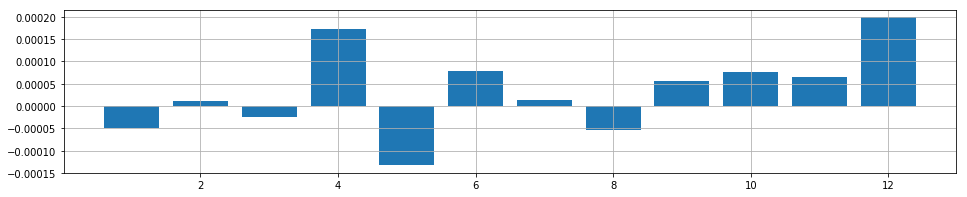

In [93]:
bars = data_merged.groupby(['Month'])['pct_change'].mean()
plt.rc("figure",figsize=(16,3))
plt.bar(bars.index,bars)
plt.grid()

# summary

In [68]:
data_merged.head(32)

OPEN    HIGH     LOW   CLOSE  Year  Month  Week  \
2001-01-02 23:00:00  0.9507  0.9509  0.9505  0.9506  2001      1     1   
2001-01-03 00:00:00  0.9506  0.9510  0.9492  0.9496  2001      1     1   
2001-01-03 01:00:00  0.9496  0.9509  0.9495  0.9505  2001      1     1   
2001-01-03 02:00:00  0.9504  0.9508  0.9498  0.9499  2001      1     1   
2001-01-03 03:00:00  0.9499  0.9507  0.9499  0.9503  2001      1     1   
2001-01-03 04:00:00  0.9503  0.9506  0.9503  0.9506  2001      1     1   
2001-01-03 05:00:00  0.9506  0.9507  0.9505  0.9505  2001      1     1   
2001-01-03 06:00:00  0.9505  0.9513  0.9503  0.9509  2001      1     1   
2001-01-03 07:00:00  0.9510  0.9510  0.9468  0.9489  2001      1     1   
2001-01-03 08:00:00  0.9490  0.9543  0.9489  0.9539  2001      1     1   
2001-01-03 09:00:00  0.9539  0.9549  0.9526  0.9541  2001      1     1   
2001-01-03 10:00:00  0.9542  0.9565  0.9534  0.9565  2001      1     1   
2001-01-03 11:00:00  0.9564  0.9569  0.9541  0.9547  2001      1     1   
2001-01-03 12:00:00  0.9548  0.9549  0.9527  0.9527  2001      1     1   
2001-01-03 13:00:00  0.9528  0.9533  0.9503  0.9513  2001      1     1   
2001-01-03 14:00:00  0.9513  0.9520  0.9475  0.9491  2001      1     1   
2001-01-03 15:00:00  0.9491  0.9498  0.9444  0.9462  2001      1     1   
2001-01-03 16:00:00  0.9460  0.9477  0.9450  0.9473  2001      1     1   
2001-01-03 17:00:00  0.9474  0.9477  0.9446  0.9449  2001      1     1   
2001-01-03 18:00:00  0.9451  0.9463  0.9337  0.9340  2001      1     1   
2001-01-03 19:00:00  0.9341  0.9355  0.9273  0.9288  2001      1     1   
2001-01-03 20:00:00  0.9290  0.9297  0.9275  0.9283  2001      1     1   
2001-01-03 21:00:00  0.9284  0.9292  0.9270  0.9272  2001      1     1   
2001-01-03 22:00:00  0.9273  0.9278  0.9262  0.9271  2001      1     1   
2001-01-03 23:00:00  0.9271  0.9285  0.9269  0.9283  2001      1     1   
2001-01-04 00:00:00  0.9283  0.9308  0.9283  0.9301  2001      1     1   
2001-01-04 01:00:00  0.9301  0.9306  0.9290  0.9294  2001      1     1   
2001-01-04 02:00:00  0.9294  0.9298  0.9290  0.9297  2001      1     1   
2001-01-04 03:00:00  0.9297  0.9302  0.9297  0.9301  2001      1     1   
2001-01-04 04:00:00  0.9300  0.9304  0.9299  0.9303  2001      1     1   
2001-01-04 05:00:00  0.9303  0.9304  0.9290  0.9291  2001      1     1   
2001-01-04 06:00:00  0.9291  0.9324  0.9290  0.9320  2001      1     1   

                     Weekday  DayMonth         TSI       ATR        WT1  \
2001-01-02 23:00:00        1         2    0.000000  0.000400  50.000000   
2001-01-03 00:00:00        2         3 -100.000000  0.001124  -9.871351   
2001-01-03 01:00:00        2         3  -51.126361  0.001223   6.524603   
2001-01-03 02:00:00        2         3  -43.544379  0.001161  10.228013   
2001-01-03 03:00:00        2         3  -35.510076  0.001079  23.696245   
2001-01-03 04:00:00        2         3  -28.715653  0.000925  37.938837   
2001-01-03 05:00:00        2         3  -24.837550  0.000799  46.394716   
2001-01-03 06:00:00        2         3  -20.212647  0.000831  55.777291   
2001-01-03 07:00:00        2         3  -22.200497  0.001316  25.059167   
2001-01-03 08:00:00        2         3   -8.796174  0.001863  40.198041   
2001-01-03 09:00:00        2         3   -0.458289  0.001917  53.499517   
2001-01-03 10:00:00        2         3    8.629703  0.002057  63.451395   
2001-01-03 11:00:00        2         3   12.032576  0.002141  67.460460   
2001-01-03 12:00:00        2         3   11.855551  0.002147  64.854505   
2001-01-03 13:00:00        2         3   10.227008  0.002236  57.030706   
2001-01-03 14:00:00        2         3    7.014706  0.002461  45.045513   
2001-01-03 15:00:00        2         3    2.381035  0.002745  30.863524   
2001-01-03 16:00:00        2         3   -0.329852  0.002741  20.227978   
2001-01-03 17:00:00        2         3   -3.813143  0.002774  11.167130   
2001-01-03 18:00:00        2         3  -11.819431  0.003649  -2.110024   
2001-

In [69]:
data_merged.describe()

OPEN           HIGH            LOW          CLOSE  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean        1.232645       1.233632       1.231669       1.232648   
std         0.160370       0.160502       0.160229       0.160366   
min         0.835500       0.836200       0.835000       0.835400   
25%         1.125900       1.126800       1.125000       1.125900   
50%         1.256300       1.257400       1.255200       1.256300   
75%         1.344200       1.345200       1.343200       1.344200   
max         1.601400       1.603600       1.599000       1.601300   

                Year          Month           Week        Weekday  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean     2009.268369       6.422188      26.185394       2.005615   
std         5.053497       3.423886      14.927804       1.461889   
min      2001.000000       1.000000       1.000000       0.000000   
25%      2005.000000       3.000000      13.000000       1.000000   
50%      2009.000000       6.000000      26.000000       2.000000   
75%      2014.000000       9.000000      39.000000       3.000000   
max      2018.000000      12.000000      53.000000       6.000000   

            DayMonth            TSI            ATR            WT1  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean       15.682335       0.529218       0.001978       1.360912   
std         8.753765      16.425487       0.000879      29.938325   
min         1.000000    -100.000000       0.000400     -71.715085   
25%         8.000000     -11.023156       0.001394     -23.949699   
50%        16.000000       0.834216       0.001788       1.988726   
75%        23.000000      12.129261       0.002328      26.646805   
max        31.000000      53.514986       0.009999      74.035459   

                 WT2             KF            KST    HIGHESTHIGH  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean        1.365564       1.232618       0.062605       1.237866   
std        28.126132       0.160369       4.763005       0.161017   
min       -65.806085       0.837519     -27.782880       0.840400   
25%       -22.132134       1.125601      -2.598468       1.130800   
50%         2.227833       1.256259       0.130030       1.261900   
75%        24.511554       1.344288       2.787432       1.349100   
max        67.491931       1.596783      30.007173       1.603600   

           LOWESTLOW   TRADINGRANGE       MOMENTUM            RSI  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean        1.227388       0.001964       0.000020      50.262035   
std         0.159693       0.001580       0.004998      12.670383   
min         0.835000       0.000000      -0.041700       0.000000   
25%         1.120800       0.000900      -0.002300      41.361216   
50%         1.251200       0.001500       0.000000      50.344940   
75%         1.338700       0.002500       0.002400      59.189310   
max         1.593500       0.033100       0.049300      92.171446   

                MACD     MACDSIGNAL       STOCHRSI            CCI  \
count  107393.000000  107393.000000  107393.000000  107393.000000   
mean        0.000029       0.000029      50.177935       0.008867   
std         0.002488       0.002339      36.026478       2.021346   
min        -0.013403      -0.012318       0.000000     -17.757170   
25%        -0.001372      -0.001299      15.693206      -1.004108   
50%         0.000100       0.000108      50.325976       0.030375   
75%         0.001535       0.001447      84.792241       1.047500   
max         0.020723       0.019505     100.000000      19.452957   

              signal  time_diff_hours    start_price      end_price  \
count  107393.000000    107393.000000  107393.000000  107393.000000   
mean        0.077016       126.179416       1.232648       1.233635   
std         0.997034       138.319652       0.160366       0.160290   


In [48]:
data_merged[data_merged['time_diff_hours'] ==1]

OPEN    HIGH     LOW   CLOSE  Year  Month  Week  \
2001-01-03 17:00:00  0.9474  0.9477  0.9446  0.9449  2001      1     1   
2001-01-04 06:00:00  0.9291  0.9324  0.9290  0.9320  2001      1     1   
2001-01-09 10:00:00  0.9413  0.9419  0.9400  0.9413  2001      1     2   
2001-01-10 10:00:00  0.9402  0.9411  0.9393  0.9405  2001      1     2   
2001-01-12 06:00:00  0.9549  0.9564  0.9539  0.9550  2001      1     2   
2001-01-12 10:00:00  0.9525  0.9528  0.9504  0.9523  2001      1     2   
2001-01-15 12:00:00  0.9425  0.9440  0.9423  0.9428  2001      1     3   
2001-01-15 14:00:00  0.9432  0.9434  0.9408  0.9416  2001      1     3   
2001-01-16 14:00:00  0.9428  0.9428  0.9394  0.9394  2001      1     3   
2001-01-18 23:00:00  0.9424  0.9433  0.9424  0.9427  2001      1     3   
2001-01-25 07:00:00  0.9224  0.9235  0.9177  0.9192  2001      1     4   
2001-01-26 13:00:00  0.9226  0.9252  0.9206  0.9233  2001      1     4   
2001-01-29 18:00:00  0.9187  0.9193  0.9182  0.9184  2001      1     5   
2001-01-30 19:00:00  0.9273  0.9276  0.9267  0.9268  2001      1     5   
2001-02-01 14:00:00  0.9404  0.9425  0.9395  0.9424  2001      2     5   
2001-02-01 16:00:00  0.9402  0.9423  0.9383  0.9385  2001      2     5   
2001-02-02 12:00:00  0.9405  0.9415  0.9402  0.9409  2001      2     5   
2001-02-05 12:00:00  0.9405  0.9413  0.9403  0.9413  2001      2     6   
2001-02-05 23:00:00  0.9380  0.9380  0.9374  0.9374  2001      2     6   
2001-02-06 10:00:00  0.9360  0.9361  0.9334  0.9341  2001      2     6   
2001-02-09 02:00:00  0.9174  0.9184  0.9174  0.9184  2001      2     6   
2001-02-09 05:00:00  0.9183  0.9196  0.9183  0.9193  2001      2     6   
2001-02-09 16:00:00  0.9242  0.9270  0.9233  0.9267  2001      2     6   
2001-02-12 14:00:00  0.9282  0.9304  0.9282  0.9301  2001      2     7   
2001-02-12 16:00:00  0.9294  0.9297  0.9269  0.9284  2001      2     7   
2001-02-14 10:00:00  0.9204  0.9216  0.9190  0.9201  2001      2     7   
2001-02-19 05:00:00  0.9135  0.9144  0.9132  0.9144  2001      2     8   
2001-02-19 09:00:00  0.9140  0.9189  0.9138  0.9184  2001      2     8   
2001-02-20 17:00:00  0.9096  0.9103  0.9090  0.9092  2001      2     8   
2001-02-21 17:00:00  0.9073  0.9102  0.9068  0.9086  2001      2     8   
2001-02-26 13:00:00  0.9102  0.9108  0.9078  0.9096  2001      2     9   
2001-02-27 06:00:00  0.9125  0.9133  0.9113  0.9113  2001      2     9   
2001-02-27 10:00:00  0.9148  0.9156  0.9141  0.9147  2001      2     9   
2001-03-01 07:00:00  0.9233  0.9267  0.9228  0.9259  2001      3     9   
2001-03-05 07:00:00  0.9328  0.9351  0.9327  0.9333  2001      3    10   
2001-03-05 09:00:00  0.9302  0.9313  0.9295  0.9309  2001      3    10   
2001-03-06 03:00:00  0.9269  0.9271  0.9264  0.9264  2001      3    10   
2001-03-06 14:00:00  0.9270  0.9284  0.9269  0.9282  2001      3    10   
2001-03-07 07:00:00  0.9355  0.9355  0.9330  0.9337  2001      3    10   
2001-03-07 14:00:00  0.9304  0.9308  0.9277  0.9283  2001      3    10   
2001-03-08 09:00:00  0.9311  0.9321  0.9306  0.9318  2001      3    10   
2001-03-12 07:00:00  0.9328  0.9338  0.9325  0.9336  2001      3    11   
2001-03-12 14:00:00  0.9279  0.9294  0.9267  0.9280  2001      3    11   
2001-03-14 16:00:00  0.9116  0.9138  0.9110  0.9131  2001      3    11   
2001-03-14 17:00:00  0.9131  0.9141  0.9108  0.9109  2001      3    11   
2001-03-15 18:00:00  0.9025  0.9026  0.8953  0.8981  2001      3    11   
2001-03-19 06:00:00  0.8953  0.8962  0.8941  0.8948  2001      3    12   
2001-03-20 16:00:00  0.9026  0.9052  0.9026  0.9052  2001      3    12   
2001-03-22 22:00:00  0.8889  0.8895  0.8882  0.8882  2001      3    12   
2001-03-26 10:00:00  0.8917  0.8924  0.8911  0.8917  2001      3    13   
2001-03-28 15:00:00  0.8887  0.8896  0.8874  0.8887  2001      3    13   
2001-03-29 01:00:00  0.8863  0.8867  0.8862  0.8866  2001      3    13   
2001-03-29 14:00:00  0.8833  0.8847  0.8814  0.8816  2001      3    13   
2001-03-29 21:00:00  0.8828

# correlations?

In [11]:
data_merged

OPEN    HIGH     LOW   CLOSE  Year  Month  Week  \
DATETIME                                                                 
2001-01-02 23:00:00  0.9507  0.9509  0.9505  0.9506  2001      1     1   
2001-01-03 00:00:00  0.9506  0.9510  0.9492  0.9496  2001      1     1   
2001-01-03 01:00:00  0.9496  0.9509  0.9495  0.9505  2001      1     1   
2001-01-03 02:00:00  0.9504  0.9508  0.9498  0.9499  2001      1     1   
2001-01-03 03:00:00  0.9499  0.9507  0.9499  0.9503  2001      1     1   
2001-01-03 04:00:00  0.9503  0.9506  0.9503  0.9506  2001      1     1   
2001-01-03 05:00:00  0.9506  0.9507  0.9505  0.9505  2001      1     1   
2001-01-03 06:00:00  0.9505  0.9513  0.9503  0.9509  2001      1     1   
2001-01-03 07:00:00  0.9510  0.9510  0.9468  0.9489  2001      1     1   
2001-01-03 08:00:00  0.9490  0.9543  0.9489  0.9539  2001      1     1   
2001-01-03 09:00:00  0.9539  0.9549  0.9526  0.9541  2001      1     1   
2001-01-03 10:00:00  0.9542  0.9565  0.9534  0.9565  2001      1     1   
2001-01-03 11:00:00  0.9564  0.9569  0.9541  0.9547  2001      1     1   
2001-01-03 12:00:00  0.9548  0.9549  0.9527  0.9527  2001      1     1   
2001-01-03 13:00:00  0.9528  0.9533  0.9503  0.9513  2001      1     1   
2001-01-03 14:00:00  0.9513  0.9520  0.9475  0.9491  2001      1     1   
2001-01-03 15:00:00  0.9491  0.9498  0.9444  0.9462  2001      1     1   
2001-01-03 16:00:00  0.9460  0.9477  0.9450  0.9473  2001      1     1   
2001-01-03 17:00:00  0.9474  0.9477  0.9446  0.9449  2001      1     1   
2001-01-03 18:00:00  0.9451  0.9463  0.9337  0.9340  2001      1     1   
2001-01-03 19:00:00  0.9341  0.9355  0.9273  0.9288  2001      1     1   
2001-01-03 20:00:00  0.9290  0.9297  0.9275  0.9283  2001      1     1   
2001-01-03 21:00:00  0.9284  0.9292  0.9270  0.9272  2001      1     1   
2001-01-03 22:00:00  0.9273  0.9278  0.9262  0.9271  2001      1     1   
2001-01-03 23:00:00  0.9271  0.9285  0.9269  0.9283  2001      1     1   
2001-01-04 00:00:00  0.9283  0.9308  0.9283  0.9301  2001      1     1   
2001-01-04 01:00:00  0.9301  0.9306  0.9290  0.9294  2001      1     1   
2001-01-04 02:00:00  0.9294  0.9298  0.9290  0.9297  2001      1     1   
2001-01-04 03:00:00  0.9297  0.9302  0.9297  0.9301  2001      1     1   
2001-01-04 04:00:00  0.9300  0.9304  0.9299  0.9303  2001      1     1   
2001-01-04 05:00:00  0.9303  0.9304  0.9290  0.9291  2001      1     1   
2001-01-04 06:00:00  0.9291  0.9324  0.9290  0.9320  2001      1     1   
2001-01-04 07:00:00  0.9320  0.9416  0.9318  0.9416  2001      1     1   
2001-01-04 08:00:00  0.9414  0.9488  0.9414  0.9458  2001      1     1   
2001-01-04 09:00:00  0.9459  0.9474  0.9444  0.9472  2001      1     1   
2001-01-04 10:00:00  0.9471  0.9515  0.9462  0.9504  2001      1     1   
2001-01-04 11:00:00  0.9503  0.9504  0.9457  0.9465  2001      1     1   
2001-01-04 12:00:00  0.9464  0.9472  0.9421  0.9469  2001      1     1   
2001-01-04 13:00:00  0.9469  0.9470  0.9440  0.9466  2001      1     1   
2001-01-04 14:00:00  0.9465  0.9474  0.9446  0.9473  2001      1     1   
2001-01-04 15:00:00  0.9474  0.9477  0.9436  0.9442  2001      1     1   
2001-01-04 16:00:00  0.9443  0.9449  0.9432  0.9444  2001      1     1   
2001-01-04 17:00:00  0.9444  0.9489  0.9441  0.9465  2001      1     1   
2001-01-04 18:00:00  0.9466  0.9491  0.9466  0.9491  2001      1     1   
2001-01-04 19:00:00  0.9491  0.9512  0.9486  0.9496  2001      1     1   
2001-01-04 20:00:00  0.9497  0.9502  0.9482  0.9489  2001      1     1   
2001-01-04 21:00:00  0.9488  0.9498  0.9487  0.9497  2001      1     1   
2001-01-04 22:00:00  0.9497  0.9510  0.9486  0.9507  2001      1     1   
2001-01-04 23:00:00  0.9507  0.9536  0.9506  0.9532  2001      1     1   
2001-01-05 00:00:00  0.9532  0.9539  0.9523  0.9525  2001      1     1   
2001-01-05 01:00:00  0.9525  0.9536  0.9524  0.9534  2001      1     1   
2001-01-05 02:00:00  0.9534  0.9548  0.9534  0.9534  2001      1     1   
2001-01-05 03:00:00  0.9534

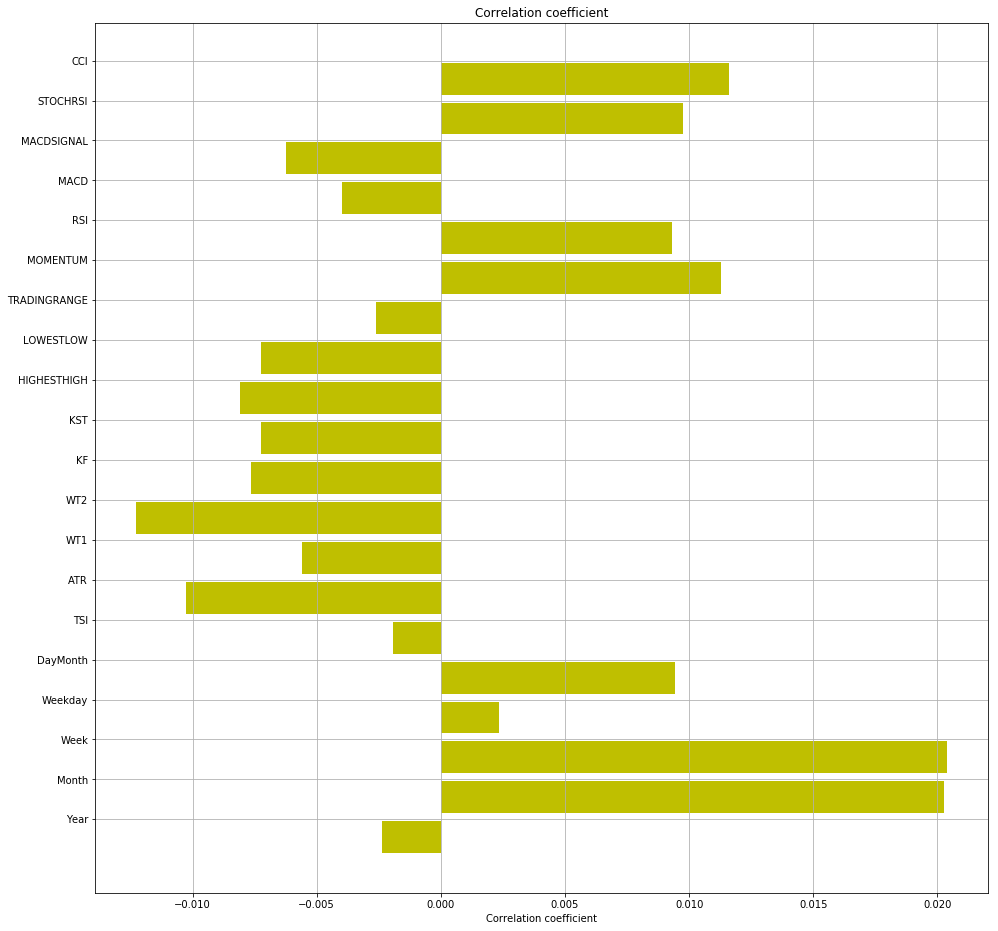

In [131]:
df = data_merged.dropna()
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price','endtime',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight']]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()


# trading rules 

In [104]:
# remove non -1 or +1 signals
#df = calc_MNE(data_merged[data_merged.time_diff_hours>0])
df[df['MNE_distance_from_start'] >0.002]
print('Zero MNE - 1 big candle: ' + str(df[df.MNE_distance_from_start == 0]['OPEN'].count()))
print('Mean MNE in pips: ' + str(df.MNE_distance_from_start.mean()))
print('Mean MNE time in seconds: ' + str(np.percentile(df.MNE_time, 50)// 1000000000))
data_signal_mne = df[df['time_diff_hours'] !=1]
data_signal_mne = data_signal_mne[(data_signal_mne['MNE_time']!=data_signal_mne['endtime'])]
data_signal_mne.describe()

Zero MNE - 1 big candle: 6330
Mean MNE in pips: 0.005113487083827611
Mean MNE time in seconds: 3600 nanoseconds


OPEN          HIGH          LOW         CLOSE          Year  \
count  79866.000000  79866.000000  79866.00000  79866.000000  79866.000000   
mean       1.231484      1.232287      1.23070      1.231497   2009.536749   
std        0.157880      0.157982      0.15778      0.157884      5.184517   
min        0.835500      0.836200      0.83500      0.835400   2001.000000   
25%        1.127400      1.128100      1.12670      1.127300   2005.000000   
50%        1.251400      1.252200      1.25070      1.251400   2010.000000   
75%        1.340900      1.341800      1.34010      1.340900   2014.000000   
max        1.600700      1.602100      1.59840      1.601300   2018.000000   

              Month          Week       Weekday      DayMonth           TSI  \
count  79866.000000  79866.000000  79866.000000  79866.000000  79866.000000   
mean       6.474908     26.419528      1.966970     15.732001      0.794788   
std        3.399165     14.839986      1.476233      8.780377     16.354793   
min        1.000000      1.000000      0.000000      1.000000   -100.000000   
25%        4.000000     14.000000      1.000000      8.000000    -10.690564   
50%        7.000000     26.000000      2.000000     16.000000      1.118420   
75%        9.000000     39.000000      3.000000     23.000000     12.379641   
max       12.000000     53.000000      6.000000     31.000000     53.473724   

                ATR           WT1           WT2            KF           KST  \
count  79866.000000  79866.000000  79866.000000  79866.000000  79866.000000   
mean       0.001799      1.788033      1.772961      1.231421      0.128150   
std        0.000680     29.902330     27.917453      0.157846      4.250748   
min        0.000400    -71.689713    -65.721163      0.837584    -27.705730   
25%        0.001320    -23.261900    -21.439038      1.126928     -2.335493   
50%        0.001672      2.471918      2.709399      1.251627      0.167999   
75%        0.002138     26.963799     24.745510      1.340568      2.635715   
max        0.008686     73.607041     65.420604      1.596783     29.302409   

        HIGHESTHIGH     LOWESTLOW  TRADINGRANGE      MOMENTUM           RSI  \
count  79866.000000  79866.000000  79866.000000  79866.000000  79866.000000   
mean       1.236254      1.226584      0.001587      0.000073     50.445856   
std        0.158362      0.157296      0.001127      0.004445     12.510292   
min        0.841900      0.835000      0.000000     -0.036500      0.000000   
25%        1.132300      1.122800      0.000800     -0.002100     41.680690   
50%        1.256300      1.246300      0.001300      0.000100     50.564202   
75%        1.345200      1.335900      0.002000      0.002300     59.239436   
max        1.603600      1.593500      0.017500      0.039000     90.543629   

               MACD    MACDSIGNAL      STOCHRSI           CCI        signal  \
count  79866.000000  79866.000000  79866.000000  79866.000000  79866.000000   
mean       0.000083      0.000080     50.332174      0.032870      0.009591   
std        0.002227      0.002086     35.530820      1.806136      0.999960   
min       -0.013064     -0.011901      0.000000    -12.615521     -1.000000   
25%       -0.001238     -0.001167     16.784193     -0.904741     -1.000000   
50%        0.000126      0.000137     50.590963      0.043466      1.000000   
75%        0.001478      0.001391     84.140626      0.987544      1.000000   
max        0.019949      0.018354    100.000000     17.228984      1.000000   

       time_diff_hours   start_price     end_price    pct_change  \
count     79866.000000  79866.000000  79866.000000  79866.000000   
mean          8.721571      1.231497      1.231535      0.000034   
std          13.240616      0.157884      0.157890      0.002631   
min           2.000000      0.835400      0.835400     -0.019250   
25%           3.000000      1.127300      1.127800     -0.002085   
50%           4.000000      1.251400      1.251400      

In [224]:
from ipywidgets import interact

def plot_trade(i):
    i = int(i)
    EURUSD_temp = data_merged.iloc[i:int(1+i+data_merged['time_diff_hours'][i])]
    # start plotting
    from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
    init_notebook_mode(connected=True)
    data = [go.Candlestick(x=EURUSD_temp.index, open=EURUSD_temp['OPEN'],high=EURUSD_temp['HIGH'],low=EURUSD_temp['LOW'],
                          close=EURUSD_temp['CLOSE'])]
    py.offline.iplot(data,filename='basic_candle2')
    
def signalgenerator_wavetrend(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]) and (df['WT1'][i] <=-45):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]) and (df['WT1'][i] >=45):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'wavetrend_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

def signalgenerator_stochrsi(df):
    time = []
    signal = []
    pos = False
    long = False
    for i in range(len(df)):
        if i == 0:
            continue
        # Entry
        if (df['STOCHRSI'][i-1]<df['STOCHRSI'][i]) and (df['STOCHRSI'][i] <=10) and (df['STOCHRSI'][i-2]<df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = True
            signal.append(1)
            continue
        elif (df['STOCHRSI'][i-1]>df['STOCHRSI'][i]) and (df['STOCHRSI'][i] >=90) and (df['STOCHRSI'][i-2]>df['STOCHRSI'][i-1]):
            time.append(df.index[i])
            pos = True
            long = False
            signal.append(-1)
            continue
        #if pos and long and (df['WT1'][i-1]>df['WT2'][i-1]) and (df['WT1'][i]<=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
        #if pos and not long and (df['WT1'][i-1]<df['WT2'][i-1]) and (df['WT1'][i]>=df['WT2'][i]):
        #    pos = False
        #    time.append(df.index[i])
        #    signal.append(0)
            
    d = {'time': time, 'stochrsi_signal': signal}
    df = pd.DataFrame(data=d)
    df.index = df['time']
    df = df.drop(['time'],axis=1)
    return df

In [225]:
interact(plot_trade, i='1');

interactive(children=(Text(value='1', description='i'), Output()), _dom_classes=('widget-interact',))

# wavetrend generator

In [ ]:
wt_signal = signalgenerator_wavetrend(data_merged)
signal_wt_df = data_merged.merge(wt_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_wt_df['end_price']-signal_wt_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_wt_df.query('signal == wavetrend_signal'))) + ' out of: '+str(len(signal_wt_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

# stochrsi generator

In [ ]:
srsi_signal = signalgenerator_stochrsi(data_merged)
signal_srsi_df = data_merged.merge(srsi_signal, left_index=True,right_index =True, how='inner')
gainz = sum( abs(signal_srsi_df['end_price']-signal_srsi_df['start_price'])*10000 )
print('---WaveTrend: '+ str(len(signal_srsi_df.query('signal == stochrsi_signal'))) + ' out of: '+str(len(signal_srsi_df))+ ' correct with: ' + str(round(gainz,5)) + ' pips')

# mixed wavetrend and stochrsi

In [ ]:
signal_overall = data_merged.merge(wt_signal, left_index=True,right_index =True, how='left').merge(srsi_signal, left_index=True,right_index =True, how='left')
signal_overall['stochrsi_signal'] = signal_overall['stochrsi_signal'].fillna(method='ffill')
#signal_overall = signal_overall.dropna()
signal_overall = signal_overall.query('wavetrend_signal == stochrsi_signal')
print('---WaveTrend: '+ str(len(signal_overall.query('signal == wavetrend_signal'))) + ' out of: '+str(len(signal_overall))+ ' correct')

In [ ]:
df = signal_overall
# Now let us look at the correlation coefficient of each of these variables
x_cols = [col for col in df.columns if col not in ['OPEN','HIGH','LOW','CLOSE','start_price','end_price',
                                                   'time_diff_hours','pct_change','weighted_target','signal','weight',]]

target_col = 'signal'
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df[target_col].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(16,16))
plt.grid(True)
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient")
#autolabel(rects)
plt.show()
